### tool 설치

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs

In [10]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


### 사전 학습된 모델 사용

In [1]:
from transformers import pipeline

camembert_fill_mask = pipeline("fill-mask", model="camembert-base")
results = camembert_fill_mask("Le camembert est <mask> :)")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from

In [2]:
results

[{'score': 0.4909118711948395,
  'token': 7200,
  'token_str': 'délicieux',
  'sequence': 'Le camembert est délicieux :)'},
 {'score': 0.10556942969560623,
  'token': 2183,
  'token_str': 'excellent',
  'sequence': 'Le camembert est excellent :)'},
 {'score': 0.034533195197582245,
  'token': 26202,
  'token_str': 'succulent',
  'sequence': 'Le camembert est succulent :)'},
 {'score': 0.033031314611434937,
  'token': 528,
  'token_str': 'meilleur',
  'sequence': 'Le camembert est meilleur :)'},
 {'score': 0.030076298862695694,
  'token': 1654,
  'token_str': 'parfait',
  'sequence': 'Le camembert est parfait :)'}]

모델 아키텍처를 직접 사용하여 체크포인트를 인스턴스화할 수도 있다.

In [3]:
from transformers import CamembertTokenizer, CamembertForMaskedLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForMaskedLM.from_pretrained("camembert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


설계상 아키텍처에 구애받지 않으려면 Auto클래스를 사용하는 것이 좋다.

In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("camembert-base")
model = AutoModelForMaskedLM.from_pretrained("camembert-base")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 사전 훈련된 모델 공유

새 모델 리포지토리를 만드는 방법에는 세 가지가 있다.

* push_to_hub API 사용
* huggingface_hubPython 라이브러리 사용
* 웹 인터페이스 사용

In [5]:
!git config --global user.email "duwltn1301@naver.com"
!git config --global user.name "YeoJiSu"

#### 📌 push_to_hub API 사용

In [95]:
from huggingface_hub import notebook_login

notebook_login()

In [83]:
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("glue", "cola")
raw_datasets = raw_datasets.rename_column("label", "labels")

In [84]:
# 토크나이저
from transformers import AutoTokenizer
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [85]:
def preprocess_function(examples):
  return tokenizer(examples["sentence"], truncation=True)

tokenized_datasets = raw_datasets.map(preprocess_function, batched = True,  remove_columns=["sentence",  "idx"])

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [86]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1063
    })
})

In [87]:
# 모델 준비
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
# 평가 함수 준비
import numpy as np
from datasets import load_metric

metric = load_metric("glue", "cola")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = -1)
  return metric.compute(predictions = predictions, references = labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [89]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-fine-tuned-cola",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,
    num_train_epochs = 3,
    weight_decay = 0.01,
    push_to_hub = True,
    hub_model_id = "YeoJiSu/bert-fine-tuned-cola",

)

In [90]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics = compute_metrics,
    tokenizer=tokenizer,
)

이제 여기서 trainer.train()을 호출 하면 Trainer모델이 네임스페이스의 저장소에 저장될 때마다(여기에서는 매 에포크마다) 모델을 허브에 업로드한다!

In [91]:
trainer.train()

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.461300,0.465200,0.513248
2,0.349600,0.661935,0.588298
3,0.197000,0.725590,0.590465


TrainOutput(global_step=3207, training_loss=0.35113329005680016, metrics={'train_runtime': 214.1897, 'train_samples_per_second': 119.768, 'train_steps_per_second': 14.973, 'total_flos': 243897267764580.0, 'train_loss': 0.35113329005680016, 'epoch': 3.0})

In [96]:
trainer.push_to_hub("End of training")

events.out.tfevents.1706537801.e7969dcb45ce.3748.0:   0%|          | 0.00/9.35k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1706538304.e7969dcb45ce.3748.1:   0%|          | 0.00/4.69k [00:00<?, ?B/s]

events.out.tfevents.1706539288.e7969dcb45ce.3748.6:   0%|          | 0.00/6.68k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

events.out.tfevents.1706538591.e7969dcb45ce.3748.2:   0%|          | 0.00/4.69k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/YeoJiSu/bert-fine-tuned-cola/commit/e915b375d000a33b34c63e3c8748dc22dbb868e2', commit_message='End of training', commit_description='', oid='e915b375d000a33b34c63e3c8748dc22dbb868e2', pr_url=None, pr_revision=None, pr_num=None)

이렇게 아래와 같이 model card가 생성되어 업로드 된 것을 확인할 수 있다.

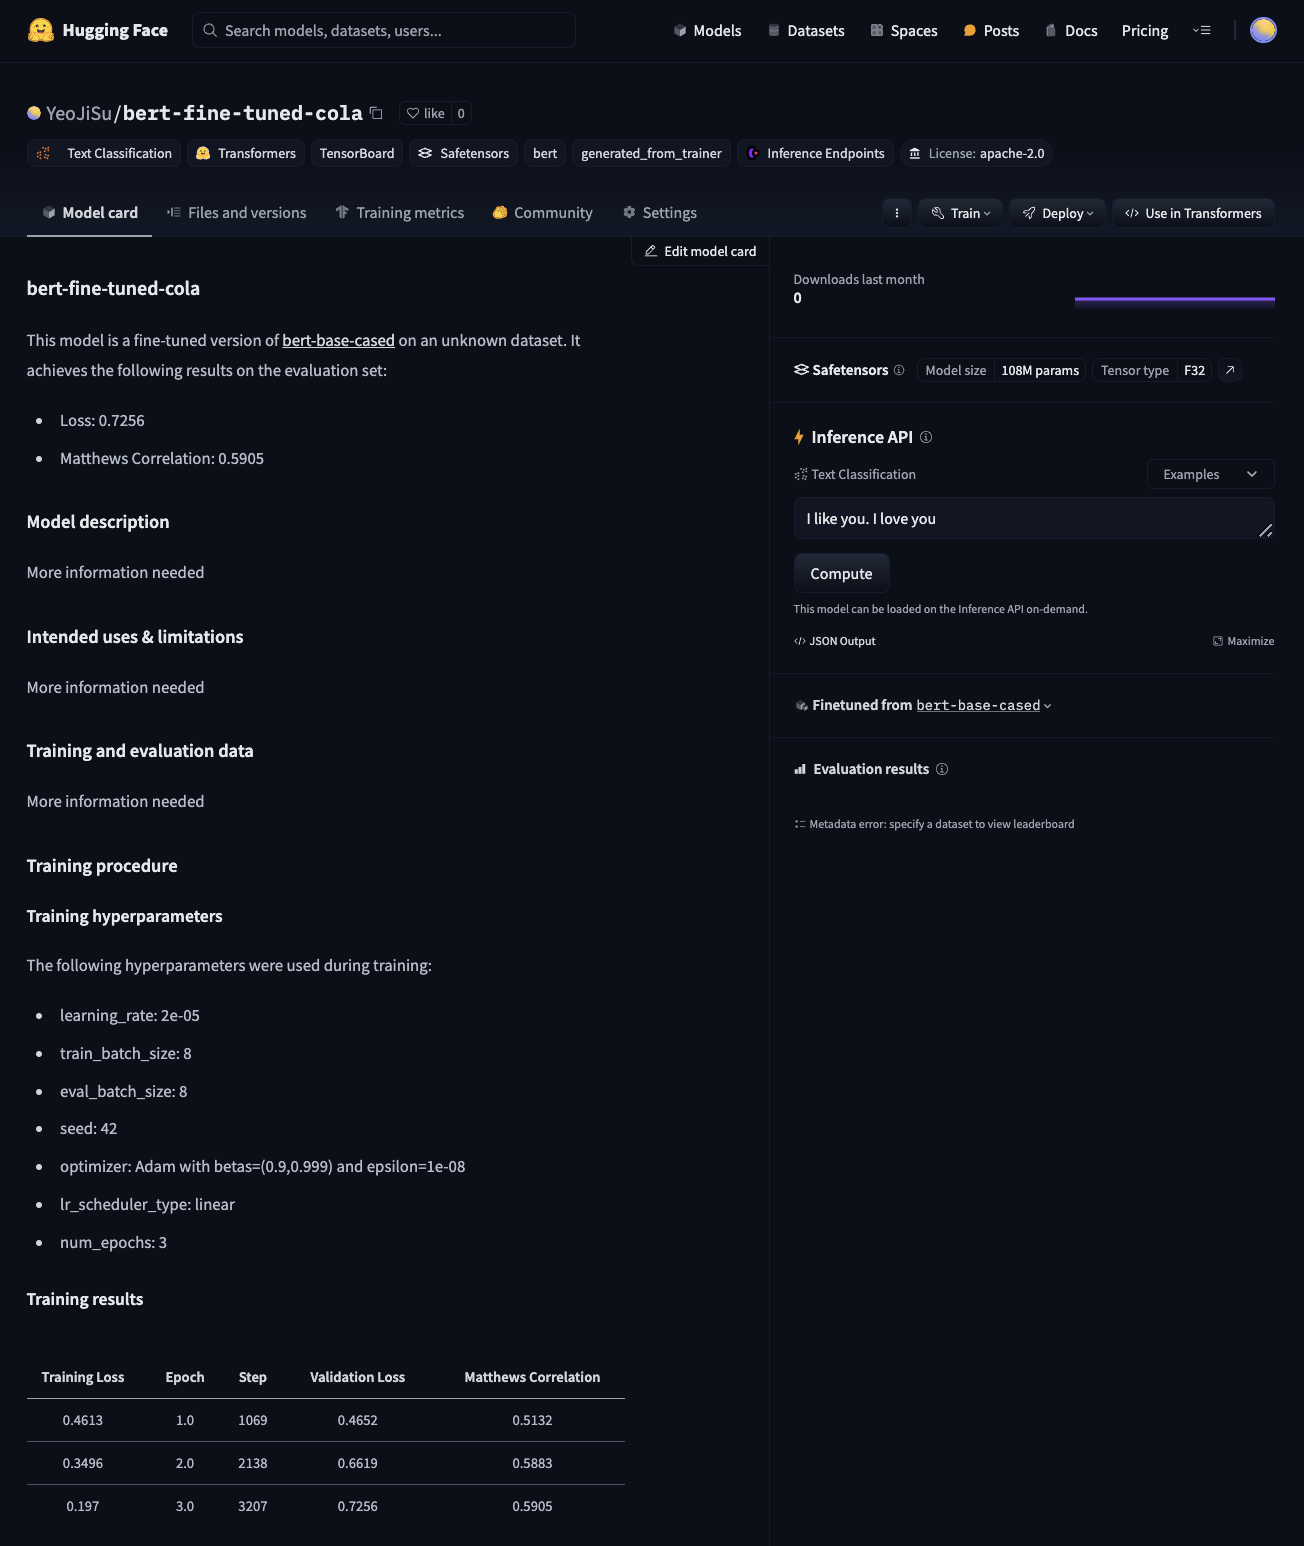

다른 방안

In [ ]:
from huggingface_hub import (
    # User management
    login,
    logout,
    whoami,

    # Repository creation and management
    create_repo,
    delete_repo,
    update_repo_visibility,

    # And some methods to retrieve/change information about the content
    list_models,
    list_datasets,
    list_metrics,
    list_repo_files,
    upload_file,
    delete_file,
)

In [ ]:
from huggingface_hub import create_repo

create_repo("dummy-model")

In [ ]:
from huggingface_hub import create_repo

create_repo("dummy-model", organization="huggingface")

In [ ]:
from huggingface_hub import upload_file

upload_file(
    "<path_to_file>/config.json",
    path_in_repo="config.json",
    repo_id="<namespace>/dummy-model",
)

In [ ]:
from huggingface_hub import Repository

repo = Repository("<path_to_dummy_folder>", clone_from="<namespace>/dummy-model")

In [ ]:
repo.git_pull()
repo.git_add()
repo.git_commit()
repo.git_push()
repo.git_tag()

In [ ]:
repo.git_pull()

In [ ]:
model.save_pretrained("<path_to_dummy_folder>")
tokenizer.save_pretrained("<path_to_dummy_folder>")

In [ ]:
repo.git_add()
repo.git_commit("Add model and tokenizer files")
repo.git_push()

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

checkpoint = "camembert-base"

model = AutoModelForMaskedLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Do whatever with the model, train it, fine-tune it...

model.save_pretrained("<path_to_dummy_folder>")
tokenizer.save_pretrained("<path_to_dummy_folder>")